## Geospatial Analysis of Thomas Fire Burn Area (2017)

![Thomas Fire at Faria Beach](data/Thomas-Fire-Faria-Beach.jpg)

Photo Credit: [Ray Ford, Noozhawk](https://news.ucsb.edu/2023/021283/thomas-fire-research-reveals-ash-can-fertilize-oceans)

### About
In December 2017, the Thomas Fire burned through 281,000 acres of land spread through both Santa Barbara and Ventura counties. According to the California Department of Forestry and Fire Protection, the Thomas Fire destroyed 1,063 residential & commercial structures and injured 2 fire personnel. The impacts of the fire were not only devasting for humans, but also for the surrounding environment. The Thomas Fire devasted wildlife, displaced many ecological communities, and caused poor quality for an extended period of time. 

The **motivation** for this post is to demonstrate how to use geospatial analysis in Python to analyze the environmental impacts of the Thomas Fire. We'll first analyze air quality data in Santa Barbara county from the months leading up to the fire and following the fire. Then, we'll use satellite imagery of multispectral bands to try to visualize the burn scar. Finally, we'll use land use and land cover data to identify the types of ecosystems that were affected by the fire.


### Github Repository

The full analysis is located in this Github repository:
[https://github.com/katleyq/eds220-thomas-fire-final](https://github.com/katleyq/eds220-thomas-fire-final)

### Highlights
In this analysis of the Thomas Fire, we'll accomplish the following:
- Time series analysis and visualization of air quality index (AQI) of affected burn area
- Raster analysis of landsat data to visualize burn areas using false color image
- Analysis of landcover statistics to visualize ecosystems affected by fire


### Data

This repository utilizes the following datasets:

1) **Air Quality Index (AQI)**: This data was retrieved from the [US Environmental Protection Agency](https://www.epa.gov). It contains air quality data throughout the US, and we subset this dataset for Santa Barbara County.

2) **Thomas Fire Perimeter Data**: This data was retrieved from US governement's data catalogue. It contains spatial data regarding fire perimeters and associated metadata. We subset this data for the 2017 Thomas Fire. (Original Source:  [California Fire Perimeter Data](https://catalog.data.gov/dataset/california-fire-perimeters-all-b3436))

3) **Landsat Data**: This data was retrieved from the Microsoft Planetary Computer Data Catalogue, pre-processed by Dr. Carmen Galaz-Garcia, and stored on the MEDS computational server. This data contains multispectral data for the area of interest. (Original Source:  [Microsoft Planetary Computer Data Catalogue](https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2))


### Import libraries

The first step of our analysis is to import all relevant libraries. We'll use the following libraries throughout this analysis:

In [1]:
import pandas as pd # Dataframe manipulation
import matplotlib.pyplot as plt # Plotting
import os # To construct file paths
import xarray as xr # To work with arrays
import rioxarray as rioxr # To work with netCDFs
import geopandas as gpd # To maniplate spatial data frames
from shapely.geometry import box  # To create polygon bounding box
from matplotlib_scalebar.scalebar import ScaleBar # for map scalebar
import matplotlib.patches as mpatches # for map legend
from matplotlib.offsetbox import AnchoredText # for map compass

/opt/anaconda3/envs/eds220-env/lib/python3.11/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


## **Part 1** - Time Series Analysis of Air Quality Index (AQI) of Thomas Fire Burn Area

Next, we will analyze AQI in Santa Barbra over time. We'll download AQI data from 2017 through 2018 from the EPA website using a URL.


### Load Data

In [2]:
# Read in data
aqi_17 = pd.read_csv('data/daily_aqi_by_county_2017.csv')
aqi_18 = pd.read_csv('data/daily_aqi_by_county_2018.csv')

### Data Cleaning and Visualizing

The next step is to combine the data and do some cleaning so it is easier to work with for readibility and reproducibility purposes. As part of the cleaning process, we'll want to make the column names uniform by making all letter lowercase and replacing spaces with underscores. We'll then filter the full dataset for Santa Barbara county and make sure the date column is in the right data type, which is a pandas `datetime` object.

In [3]:
# Combine aqi_17 and aqi_18 observations
aqi = pd.concat([aqi_17, aqi_18])

# Simplify column names
aqi.columns = (aqi.columns
                  .str.lower()
                  .str.replace(' ','_'))
               
# Locate observations where county_name == Santa Barbara then store it as a copy in aqi_sb
aqi_sb = aqi.loc[aqi.county_name=='Santa Barbara'].copy()
               
               
# Convert date column of aqi_sb to datetime type
aqi_sb.date = pd.to_datetime(aqi_sb.date)
               
# Set the data column as the index then reassign it back to aqi_sb
aqi_sb = aqi_sb.set_index('date')

After our data is cleaned up, we'll want to take a rolling 5-day average of AQI. This is because we have daily AQI measurements in our dataset, and it would be harder to see any patterns in the data if we plot the daily AQI. The rolling 5-day average allows us to smooth the data out and produce a clearer plot.

In [4]:
# Calculate AQI rolling average over 5 day window
rolling_average = aqi_sb.aqi.rolling(window = 5).mean()
               
# Create new column in aqi_sb called five_day_average and attach rolling_average series
aqi_sb['five_day_average'] = rolling_average
               

### Plotting
Finally, we'll want to plot the data to see how AQI changes before and after the Thomas Fire. For reference, we'll add a red dotted line on the plot signifying when the Thomas Fire occurred.

Text(0.5, 0, 'Figure 1: A line plot of 5-day rolling average of air quality index for Santa Barbara County from 2017-2018.')

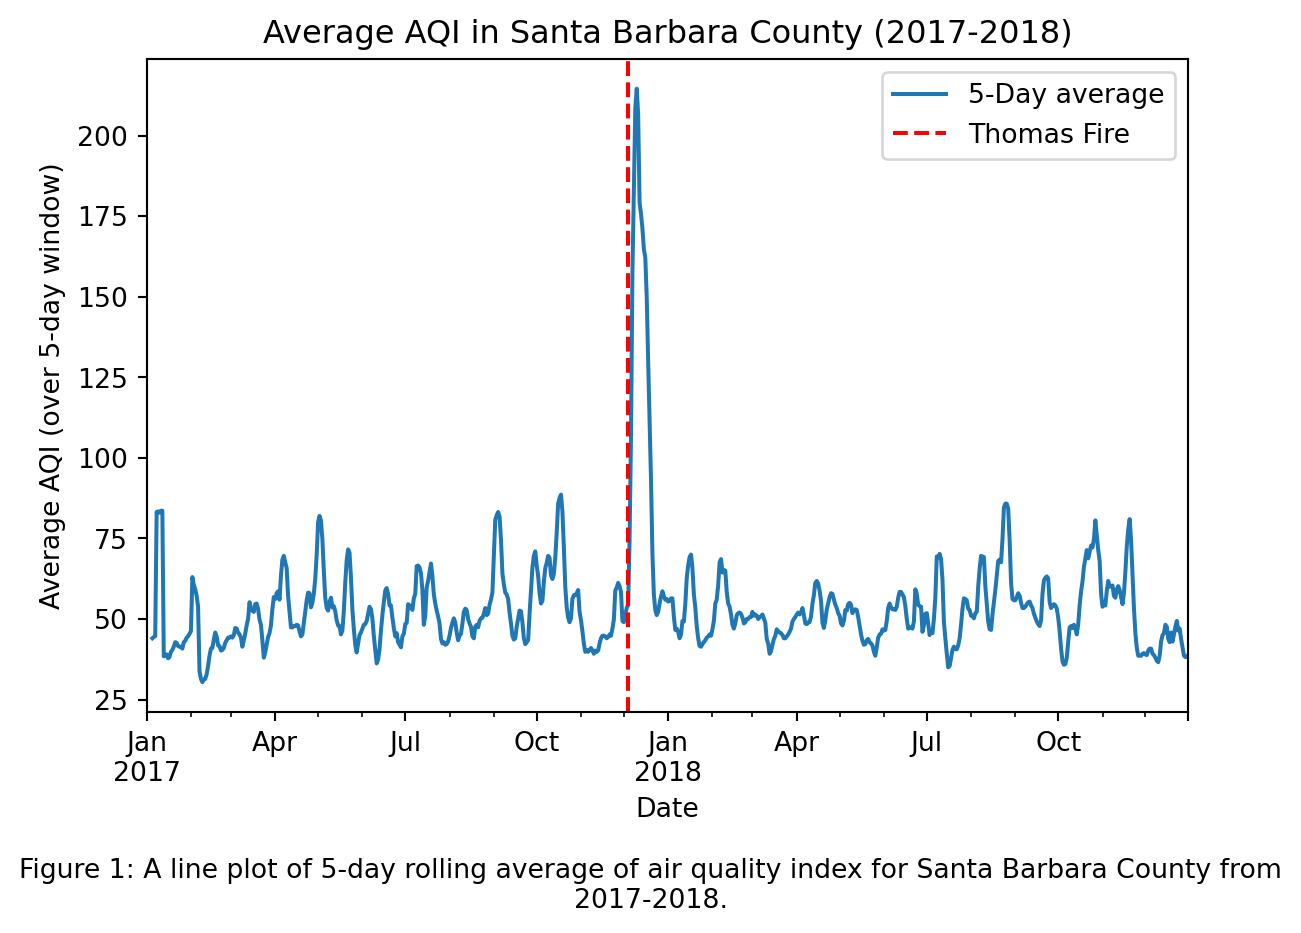

In [5]:
# Create line plot for AQI levels over time for Santa Barbara (2017-2018)
plot = (aqi_sb.plot(kind='line', y='five_day_average', label = "5-Day average"))

# Set title, xlabel, and ylabel for plot
plot.set_title("Average AQI in Santa Barbara County (2017-2018)")
plot.set_xlabel("Date")
plot.set_ylabel("Average AQI (over 5-day window)")

# Add a vertical line on December 4, 2017 which was beginning of Thomas Fire
plt.axvline(x=pd.to_datetime("2017-12-04"), color='red', linestyle='--', label = "Thomas Fire")
plt.legend()

# Adjust the layout to prevent overlap
plt.subplots_adjust(bottom=0.2)  # Increase bottom margin

# Add figure description
plt.figtext(0.5, 0, "Figure 1: A line plot of 5-day rolling average of air quality index for Santa Barbara County from 2017-2018.", wrap=True, horizontalalignment='center', fontsize=10)

The plot above shows a 5-day rolling average of air quality index in Santa Barbara County from January 2017 to Decemeber 2018. We can clearly see a signficant spike in AQI right after the Thomas Fire started.

## **Part 2** - Using landsat data to visualize Thomas Fire burn area by creating false color image

In this section, we'll create false color image of Santa Barbara county following the Thomas Fire to visualize the burn scar using landsat data. We'll plot shortwave infrared in the red channel, near infrared in the green channel, and red in the blue channel. This technique is used in remote sensing to visualize moisture content and vegetation of each pixel. This combination of spectral bands uncovers the burn scar due to wildfire, which we'll see in the Figure 2.

### Load data
We'll first load the thomas fire perimeter we retrieved from CALFIRE's fire perimeter dataset. To see how we obtained the shapefile, check out the `thomas-fire-perimeter.ipynb` notebook in the notebooks folder of this github repository.

Then we'll load the netCDF file containing landsat data using `rioxarray`.

In [6]:
# Load California Fire Perimeter shapefile
thomas_fire = gpd.read_file("data/thomas_fire.shp")

# Load landsat data
landsat = rioxr.open_rasterio("data/landsat8-2018-01-26-sb-simplified.nc")

Since the landsat data has 3 dimensions and 1 of the dimensions is redudant, we'll want want to drop the redudant dimension. We can do this by squeezing the data into 2 dimensions, then dropping the 'band' variable. The purpose of this step is to make the landsat data easier to work with and plot.

In [7]:
# Convert data to 2 dimensions then drop the band variable
landsat = landsat.squeeze().drop_vars('band')

#### **Important** : 
When working with 2 spatial datasets, we always need to ensure the coordinate reference systems (CRS) of our spatial data  match. Let's check if the CRS of the landsat and thomas fire perimeter match.

In [8]:
# Print out CRS of landsat and thomas_fire CRSs
print(f"**Landsat CRS** = {landsat.rio.crs}")
print('----')
print(f"**Thomas Fire CRS** = {thomas_fire.crs}")

**Landsat CRS** = PROJCS["WGS 84 / UTM zone 11N",GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-117],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32611"]]
----
**Thomas Fire CRS** = PROJCS["WGS_1984_Web_Mercator_Auxiliary_Sphere",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Mercator_1SP"],PARAMETER["central_meridian",0],PARAMETER["scale_factor",1],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1],AXIS["Easting",EAST],AXIS["Northing",NORTH],E

ERROR 1: PROJ: proj_identify: /opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Turns out, they do not match. This is important to address right away!

In [9]:
# Convert thomas_fire CRS to match landsat CRS
thomas_fire = thomas_fire.to_crs(landsat.rio.crs)

Okay good.. now they match. For good measure, it's good practice to incorporate a test in our code that notifies us if there's an issue with our data. Here, we'll construct an assert statement that ensures the CRS of our 2 spatial datasets match.

In [10]:
# Verify that landsat CRS is the same as thomas_fire crs before moving onto next code
assert landsat.rio.crs == thomas_fire.crs

ERROR 1: PROJ: proj_identify: /opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: proj_identify: /opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Next, we'll want to explore the height and width of the landsat data.

In [11]:
# Print the height and width of the landsat data 
print('Height: ', landsat.rio.height)
print('Width: ', landsat.rio.width)

Height:  731
Width:  870


Using this height and width, we'll create the aspect ratio. This step will be important later on when we want to plot. The aspect ratio will help avoid any distortion in the data when plotting.

In [12]:
# Calculate aspect ratio for plotting landsat data
landsat_aspect_ratio = landsat.rio.width / landsat.rio.height

### Plotting

Finally, it's time to plot our landsat data! As mentioned previously, we'll plot the false color image by plotting a combination of shortwave infrared, near infrared, and red bands in order to uncover moisture content and vegetation of each pixel. This combination uncovers the Thomas Fire burn scar that you cannot see when you plot the true color image (red, green, and blue bands). For a clearer data visualization, we'll overlay the border of the Thomas Fire polygon on top of the landsat data. We'll color it in yellow to distinguish it from the rest of the plot.

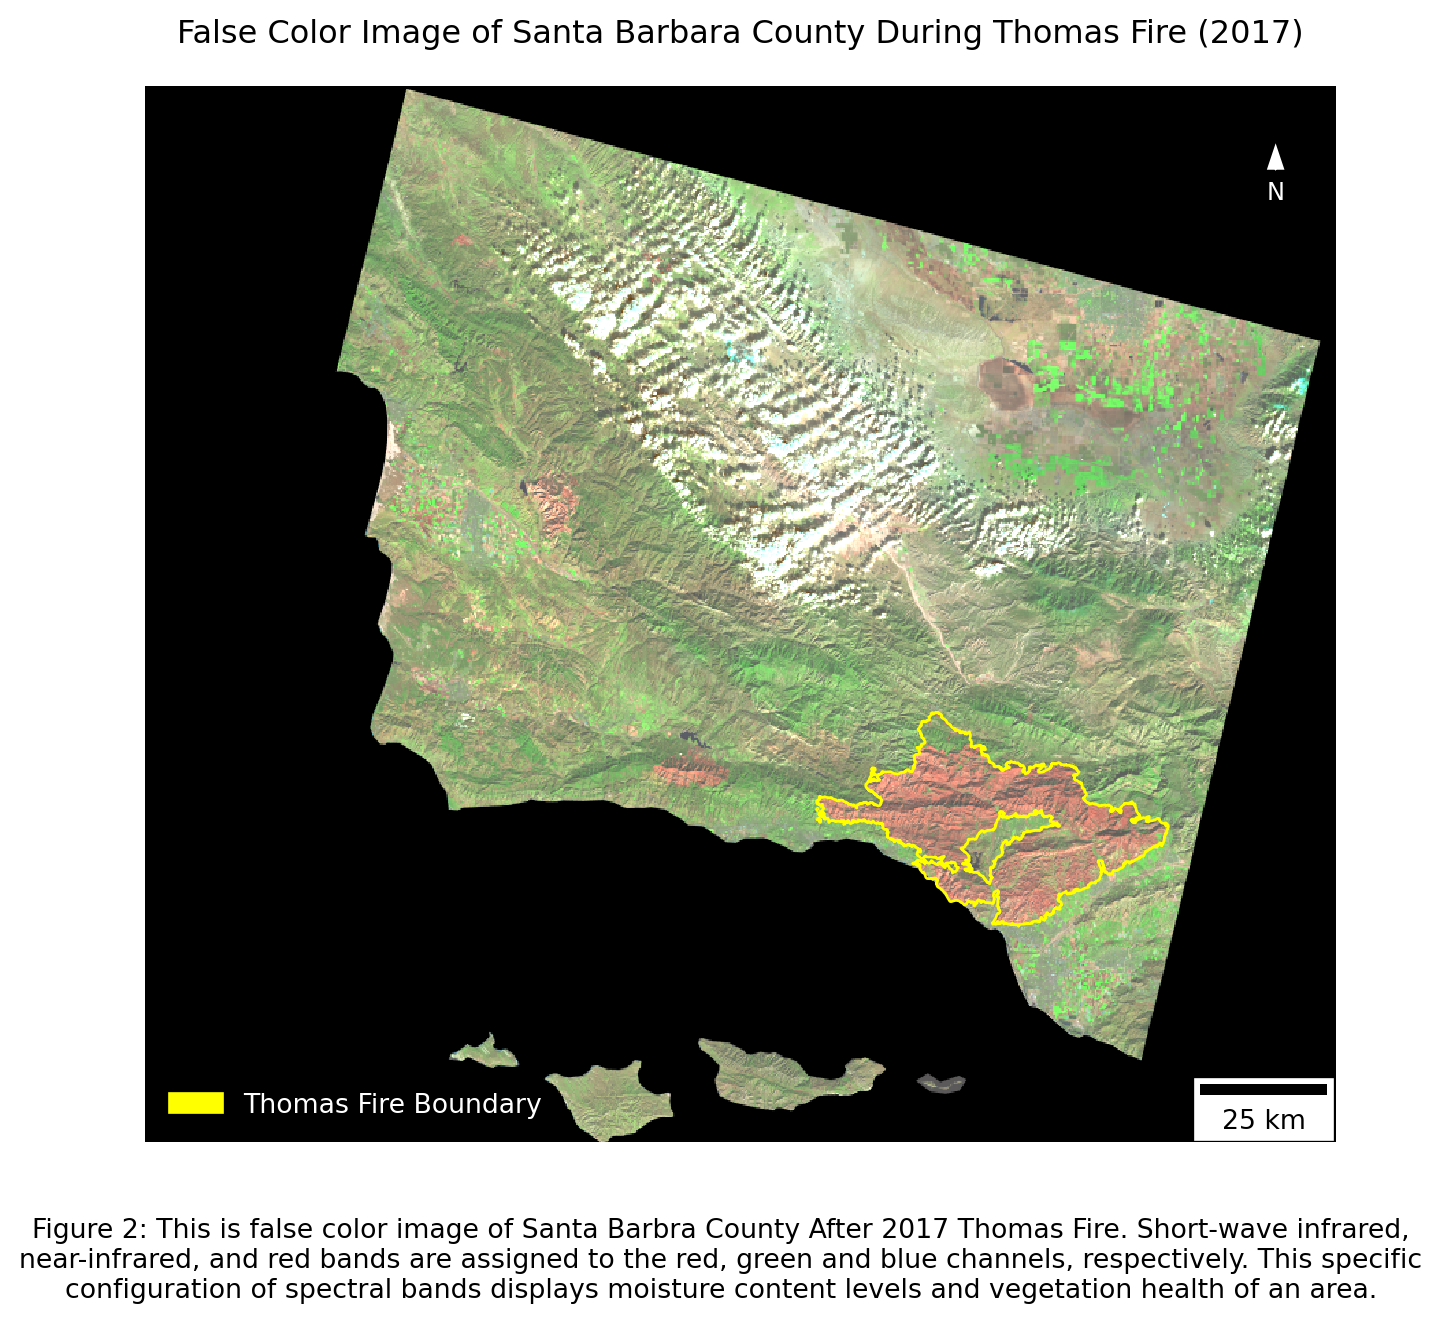

In [13]:
# Initialize a new plot with correct aspect ratio
fig, ax = plt.subplots(figsize = (8, 6*landsat_aspect_ratio))

# Remove axes
ax.axis('off')

# Overlay thomas_fire polygon
thomas_fire.plot(ax = ax,
                 color = 'none',
                edgecolor = 'yellow', 
                linewidth = 1)

# Plot shortwave infrared, near infrared, and red bands of landsat data to RGB channels respectively
landsat[['swir22', 'nir08', 'red']].to_array().plot.imshow(ax = ax, 
                                                           robust = True)
# Add title
ax.set_title('False Color Image of Santa Barbara County During Thomas Fire (2017)')

# Create scalebar
scalebar = ScaleBar(1,  # Scale in units per pixel
                    units='m',  # Set units to meters
                    location='lower right', 
                    scale_loc='bottom')  

# Add scalebar created above to plot
ax.add_artist(scalebar)

# Create legend for Thomas Fire Boundary
ax.legend(handles = [mpatches.Patch(color='yellow',
                          label='Thomas Fire Boundary')], 
          loc = "lower left",
          labelcolor = "white", 
          frameon=False)

# Add a north arrow
ax.annotate('N', xy=(0.95, 0.95), xytext=(0.95, 0.9),
            arrowprops=dict(facecolor='white', width=1, headwidth=8),
            ha='center', va='center', fontsize=9, color='white',
            xycoords='axes fraction')

# Add figure description
plt.figtext(0.5, 0, "Figure 2: This is false color image of Santa Barbra County After 2017 Thomas Fire. Short-wave infrared, near-infrared, and red bands are assigned to the red, green and blue channels, respectively. This specific configuration of spectral bands displays moisture content levels and vegetation health of an area.", wrap=True, horizontalalignment='center', fontsize=10)


plt.show()

## Part 3: Landcover statistics

(still figuring this part out)

# Conclusion

The 2017 Thomas Fire significantly impacted both humans and the environment. This geospatial analysis demonstrats the power of Python and open source data for investigating the environmental impacts of wildfire and highlighting key insights into the fire's aftermath. Through this analysis, we visualized the change in air quality in the surrounding area, identified the spatial extent of the burn scar using satellite imagery, and quantified the affected ecosystems using land cover data. 


### References
Microsoft Planetary Computer. (Access Date: November 2024). Landsat Collection 2, Level-2 [Dataset]. U.S. Geological Survey (USGS). https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2

Riebeek, H. (2014, March 4). Why is that forest red and that cloud blue? NASA Earth Observatory. https://earthobservatory.nasa.gov/features/FalseColor

U.S. Environmental Protection Agency. Air quality index data. [Dataset].  https://aqs.epa.gov/aqsweb/airdata/download_files.html

U.S. Geological Survey. (2021, November 12). Common Landsat band combinations [Image]. U.S. Department of the Interior. https://www.usgs.gov/media/images/common-landsat-band-combinations

U.S. Geological Survey. (Access Date: November 2024). California fire perimeters (all) [Dataset]. Data.gov. https://catalog.data.gov/dataset/california-fire-perimeters-all-b3436

"Thomas Fire (December 4, 2017)." California Department of Forestry and Fire Protection, https://www.fire.ca.gov/incidents/2017/12/4/thomas-fire/.